In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
from astropy.io import fits
import os

In [2]:
'''
Grabbing data from the fits file
'''


def readData(folder):
    '''
    Reads all the fits files in a folder and creates a 3D array
    '''
    files = os.listdir(folder)
    array3D = []
    for ff in files:
        arr = fits.getdata(folder+ff,ignore_missing_end=True)
        array3D.append(arr)
    return np.array(array3D)

def combineFrame(data_array):
    '''
    Avergaes the 3D into 2D array
    '''
    return np.median(data_array,axis=0)

In [25]:
'''
Reduction functions
'''

def slit_size(data = 'fits_file'):
    '''
    takes a fits file and finds the slit sized used
    '''
    dt = fits.open(data)
    header = dt[0].header
    print(header['SLIT_N'])
    
    
def norm_flat(bias_folder,flat_folder):
    '''
    Input the bias and flat folders and creates
    bias,flats, and normalized flats
    '''
    flat3d = readData(flat_folder)
    bias3d = readData(bias_folder)

    flat2d = combineFrame(flat3d)
    bias2d = combineFrame(bias3d)

    norm_flat = (flat2d-bias2d)/np.median(flat2d-bias2d)
    return norm_flat,flat2d,bias2d

def science_image(science_folder,flat_folder,bias_folder, **kwargs):
    '''
    Creates a science image and outputs the 2D array to be used to make spectra
    '''
    normflat, flat, bias = norm_flat(bias_folder,flat_folder) # creates flats and bias

    science_3d = readData(science_folder) # reducing down to 2d 
    science_2d = combineFrame(science_3d)
    science_final = (science_2d - bias)/normflat # subtracting bias and normalizing
    # Plots the science image
    plt.figure(figsize=[12,6])
    plt.imshow(science_final,origin='lower',interpolation='nearest',cmap='gray',\
               vmin=10,vmax=1000)
    if 'title' in kwargs:
        plt.title(kwargs.get('title'))
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()
    return science_final

def science_spectra(science_2d,start_slice,end_slice,file_name='file_name'):
    '''
    Creates a spectra by slicing up the science image at the input spatial
    pixels, saves array, and outputs plot
    '''
    spectra = np.mean(science_2d[start_slice:end_slice,:],axis=0)
    spectra = spectra[spectra>0]
    x = np.arange(0,len(spectra))
    plt.plot(x,spectra,color='black')
    plt.show()
    np.save('%s_spectra'%file_name,science_2d)
    return spectra



/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


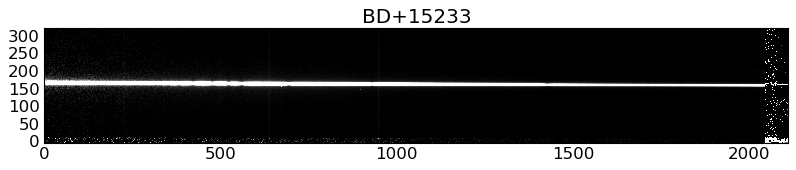

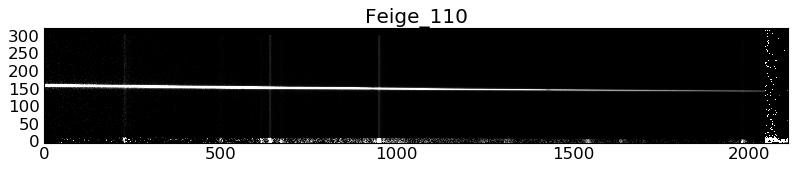

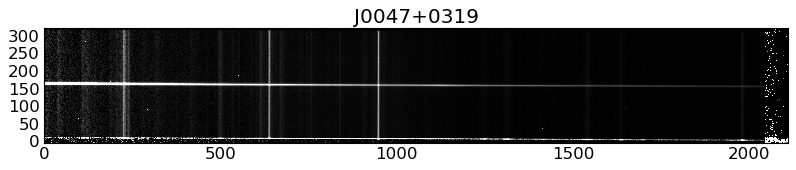

In [27]:
sources = ['BD+15233', 'Feige_110', 'J0047+0319']
for obj in sources:
    img = science_image('spectra/kast_raw/%s/'%(obj), 'spectra/kast_raw/flat/', 'spectra/kast_raw/bias/', \
                       title=obj, save='writeup/plots/kast_%s.png'%(obj))

In [24]:
img.shape

(325, 2112)